In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gpt-vectorized-data/df_vectorized.csv
/kaggle/input/sephora-products-and-skincare-reviews/product_info.csv
/kaggle/input/sephora-products-and-skincare-reviews/reviews_250_500.csv
/kaggle/input/sephora-products-and-skincare-reviews/reviews_1500_end.csv
/kaggle/input/sephora-products-and-skincare-reviews/reviews_1000_1500.csv
/kaggle/input/sephora-products-and-skincare-reviews/reviews_500_750.csv
/kaggle/input/sephora-products-and-skincare-reviews/reviews_750_1000.csv
/kaggle/input/sephora-products-and-skincare-reviews/reviews_0_250.csv


In [2]:
# Installations
!pip install scikit-llm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.9 MB/s eta 0:00:00


In [3]:
# Imports
import os
import pandas as pd
import numpy as np
from collections import Counter
from datetime import date

# Scikit-LLM
from skllm.config import SKLLMConfig
from skllm.preprocessing import GPTVectorizer


# Visualizations
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [4]:
### OPENAI API

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("ORG_ID")
secret_value_1 = user_secrets.get_secret("SECRET_KEY")

SKLLMConfig.set_openai_key(secret_value_1)
SKLLMConfig.set_openai_org(secret_value_0)

# Data

Given the size of the data set, only a small subset will be used for this activity.

- Import data
- Subset data

In [5]:
# Data
data = pd.read_csv("/kaggle/input/sephora-products-and-skincare-reviews/reviews_0_250.csv")

# Check
data.head(5)

/tmp/ipykernel_21/1823288251.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/kaggle/input/sephora-products-and-skincare-reviews/reviews_0_250.csv")


,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


In [6]:
# Shape
data.shape

(602130, 19)

In [7]:
# Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602130 entries, 0 to 602129
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                602130 non-null  int64  
 1   author_id                 602130 non-null  object 
 2   rating                    602130 non-null  int64  
 3   is_recommended            484644 non-null  float64
 4   helpfulness               270298 non-null  float64
 5   total_feedback_count      602130 non-null  int64  
 6   total_neg_feedback_count  602130 non-null  int64  
 7   total_pos_feedback_count  602130 non-null  int64  
 8   submission_time           602130 non-null  object 
 9   review_text               601131 non-null  object 
 10  review_title              435119 non-null  object 
 11  skin_tone                 496074 non-null  object 
 12  eye_color                 463642 non-null  object 
 13  skin_type                 527447 non-null  o

In [8]:
# Columns to focus analysis on 
keep_cols = ['rating', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text', 'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_name', 'brand_name', 'price_usd']

In [9]:
# Build a more focused data set
df = data[keep_cols].sample(n=25000)

# Check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 109082 to 33713
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   rating                    25000 non-null  int64  
 1   is_recommended            20134 non-null  float64
 2   helpfulness               11356 non-null  float64
 3   total_feedback_count      25000 non-null  int64  
 4   total_neg_feedback_count  25000 non-null  int64  
 5   total_pos_feedback_count  25000 non-null  int64  
 6   submission_time           25000 non-null  object 
 7   review_text               24952 non-null  object 
 8   review_title              18227 non-null  object 
 9   skin_tone                 20584 non-null  object 
 10  eye_color                 19221 non-null  object 
 11  skin_type                 21885 non-null  object 
 12  hair_color                19159 non-null  object 
 13  product_name              25000 non-null  object 
 14  b

In [10]:
# Drop all rows where review_text is NaN
df = df[df.review_text.notna()]

In [11]:
# Process review_text via GPTVectorizer()
gpt_model = GPTVectorizer(openai_embedding_model='text-embeddings-ada-002')

# Vectors
#gpt_vectors = gpt_model.fit_transform(df.review_text)

In [12]:
# Save to df
#df['gpt_vectors'] = [np.ravel(i) for i in gpt_vectors]

In [13]:
# Export to CSV
#df.to_csv('df_vectorized.csv')

## Examine the Data Structure

In [14]:
# Use the exported data set from above
df2 = pd.read_csv("/kaggle/input/gpt-vectorized-data/df_vectorized.csv", lineterminator='\n')

Text(0.5, 1.0, 'Distribution of Missing Values across the Data Set')

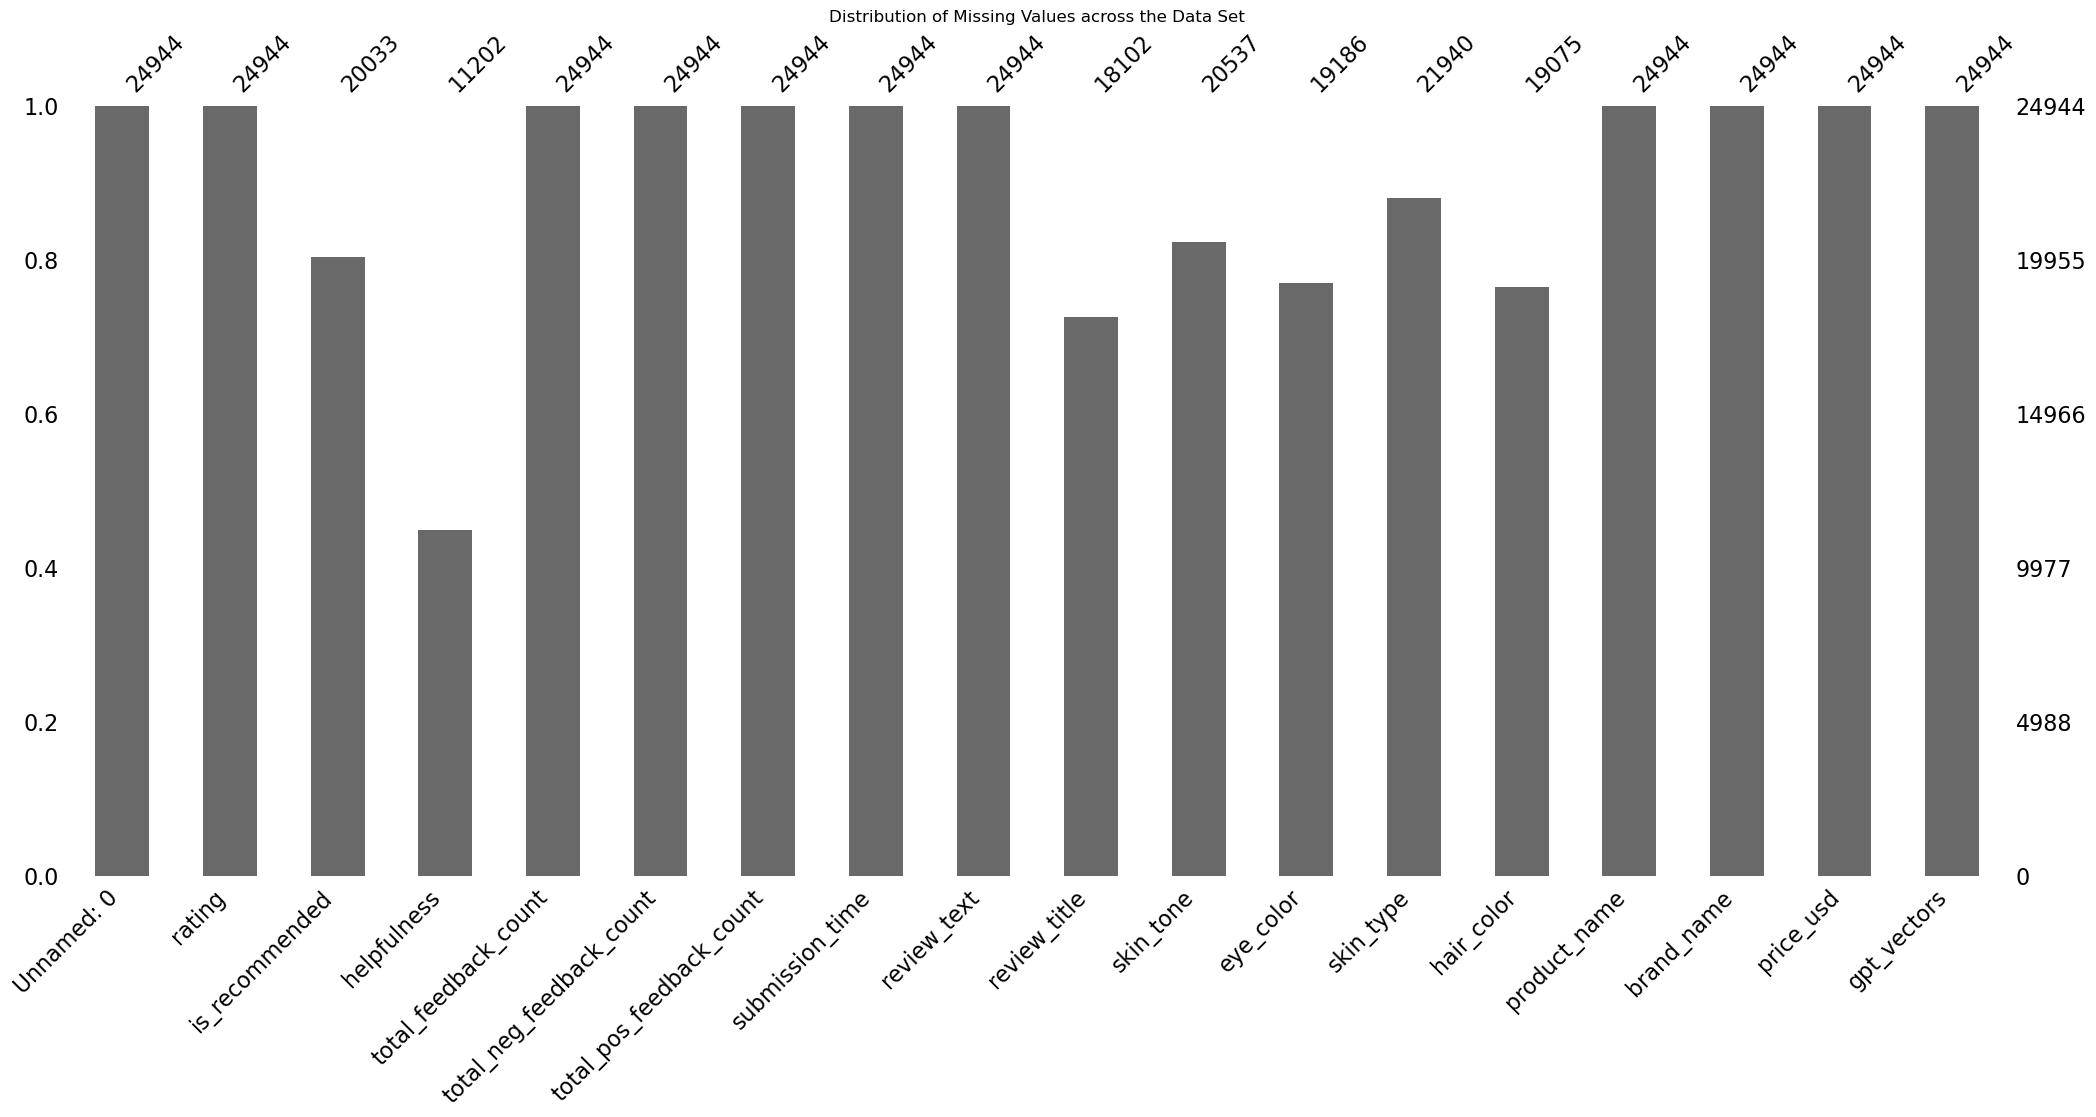

In [15]:
# Visualize the missing values
msno.bar(df2)

# Title
plt.title('Distribution of Missing Values across the Data Set')

Text(0.5, 1.0, 'Nullity Correlations')

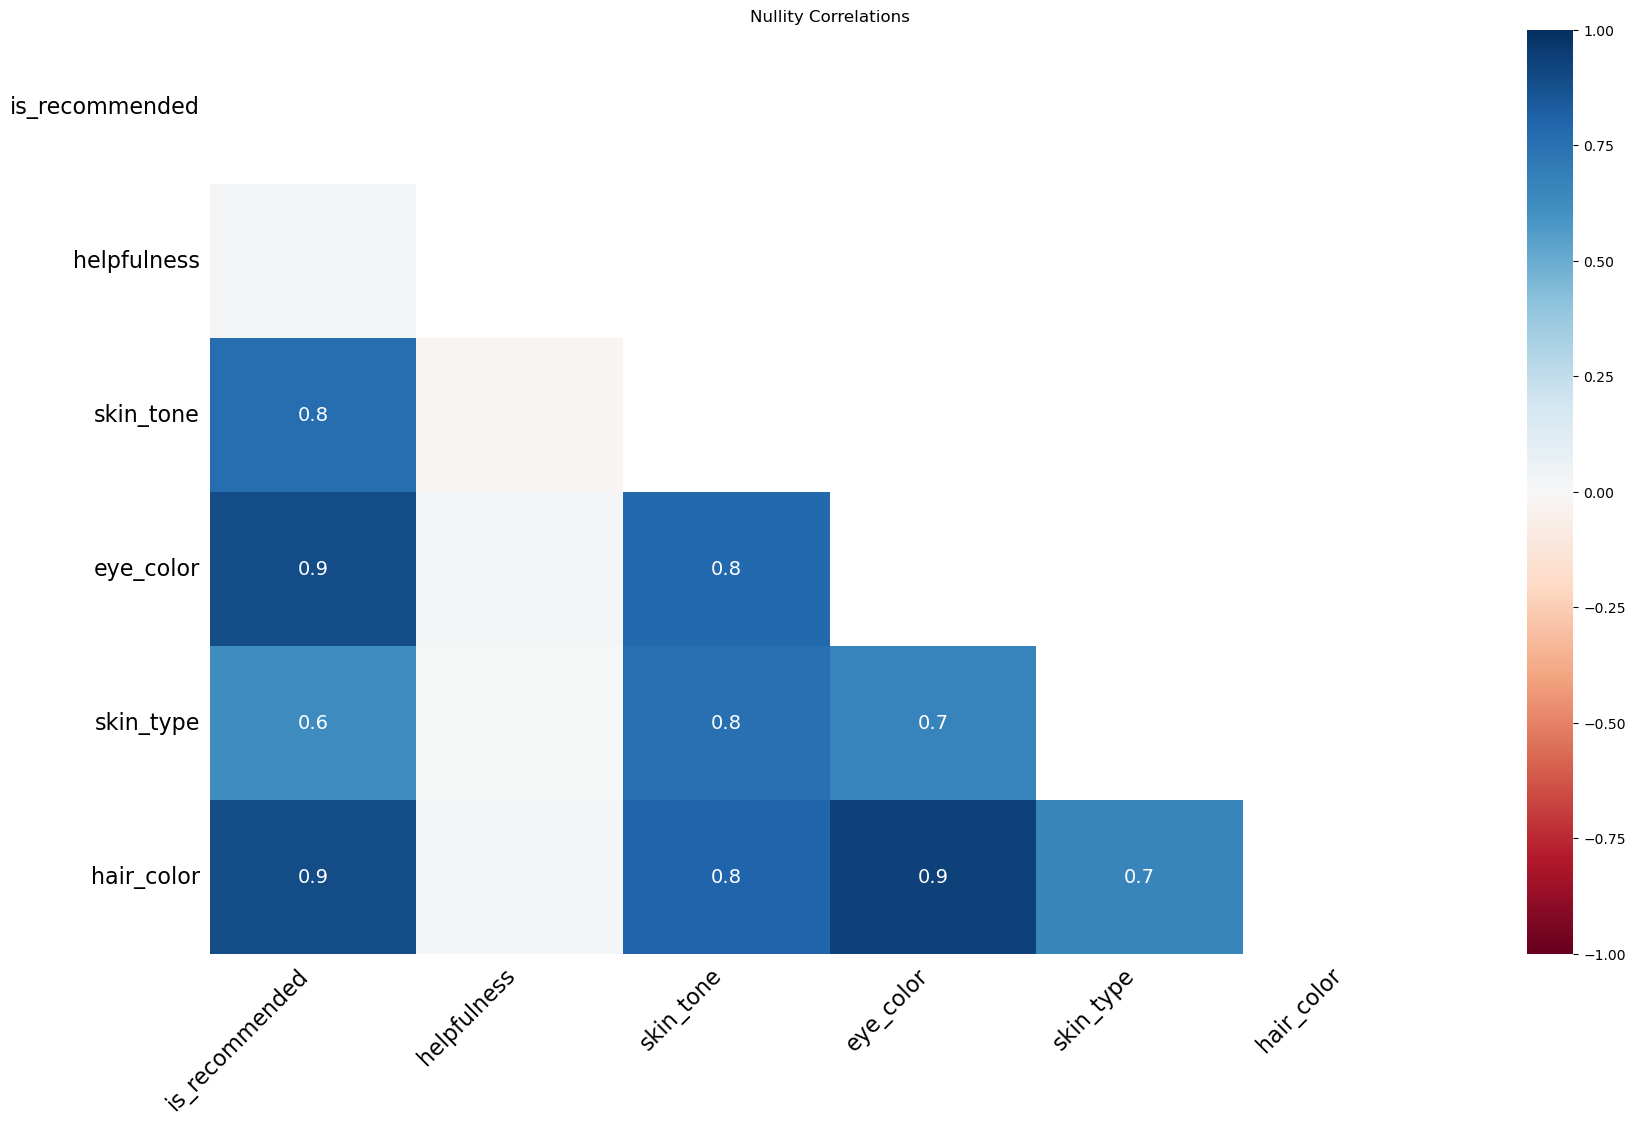

In [16]:
# Correlations among columns with missing values
heatmap_cols = [c for c in df2.columns if c != 'review_text' and c != 'review_title']

# Visualize
msno.heatmap(df2[heatmap_cols])

# Title
plt.title('Nullity Correlations')

Judging from above, strong positive correlations exist between all of the variables having null values except for helpfulness.

### Explore the Relevant Features

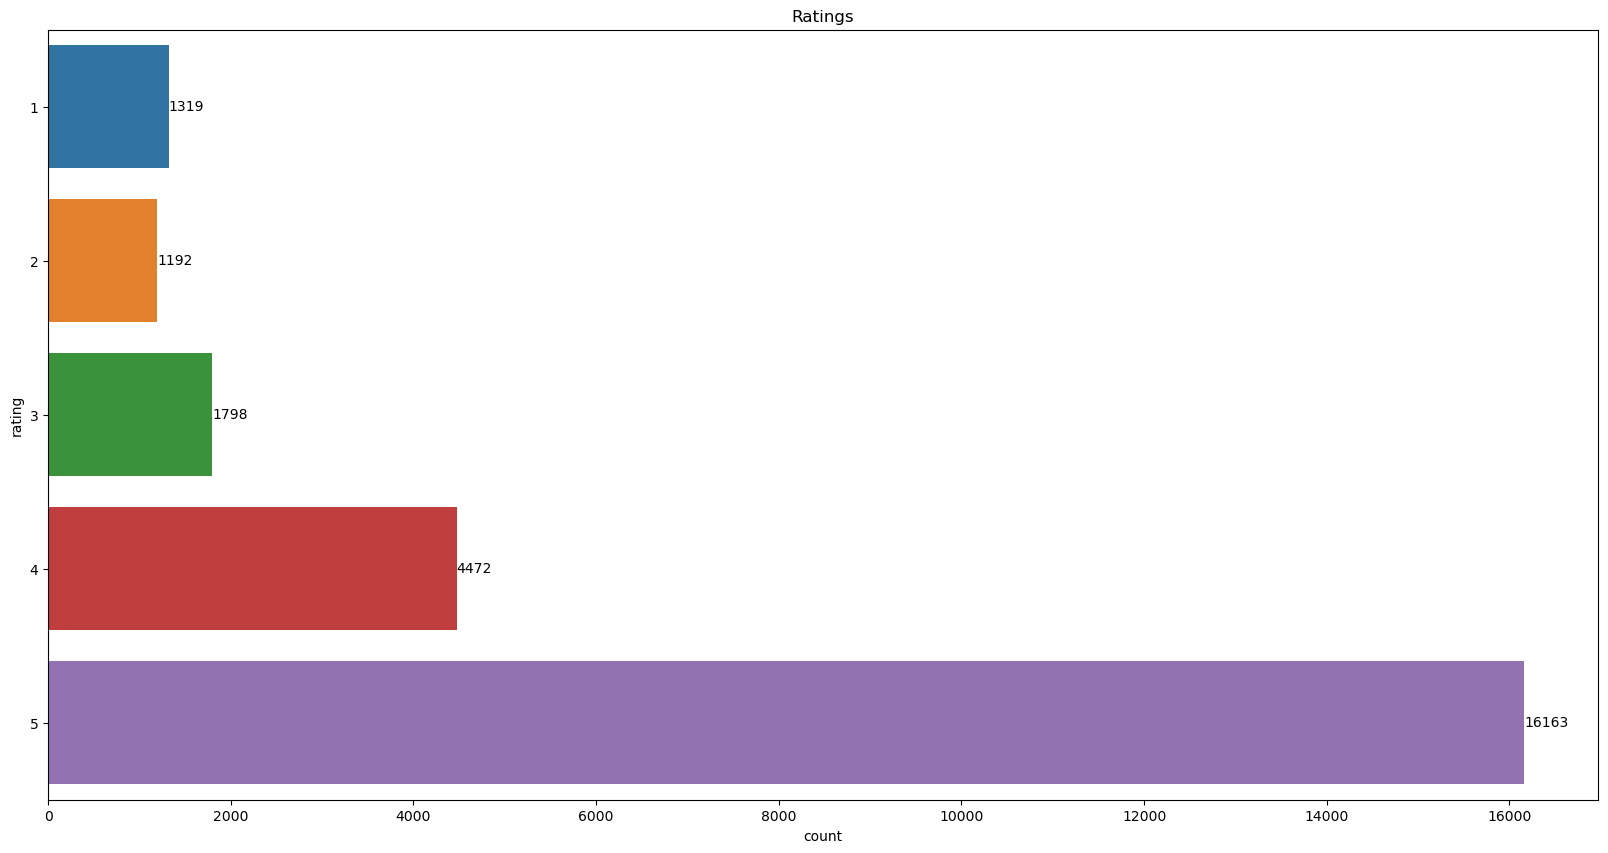

In [17]:
# Ratings
# Size
plt.figure(figsize=(20,10))

# Countplot
ratings_countplot = sns.countplot(y='rating', data=df2)
ratings_countplot.bar_label(ratings_countplot.containers[0]) # Annotations
plt.title('Ratings') # Title

# Show
plt.show()

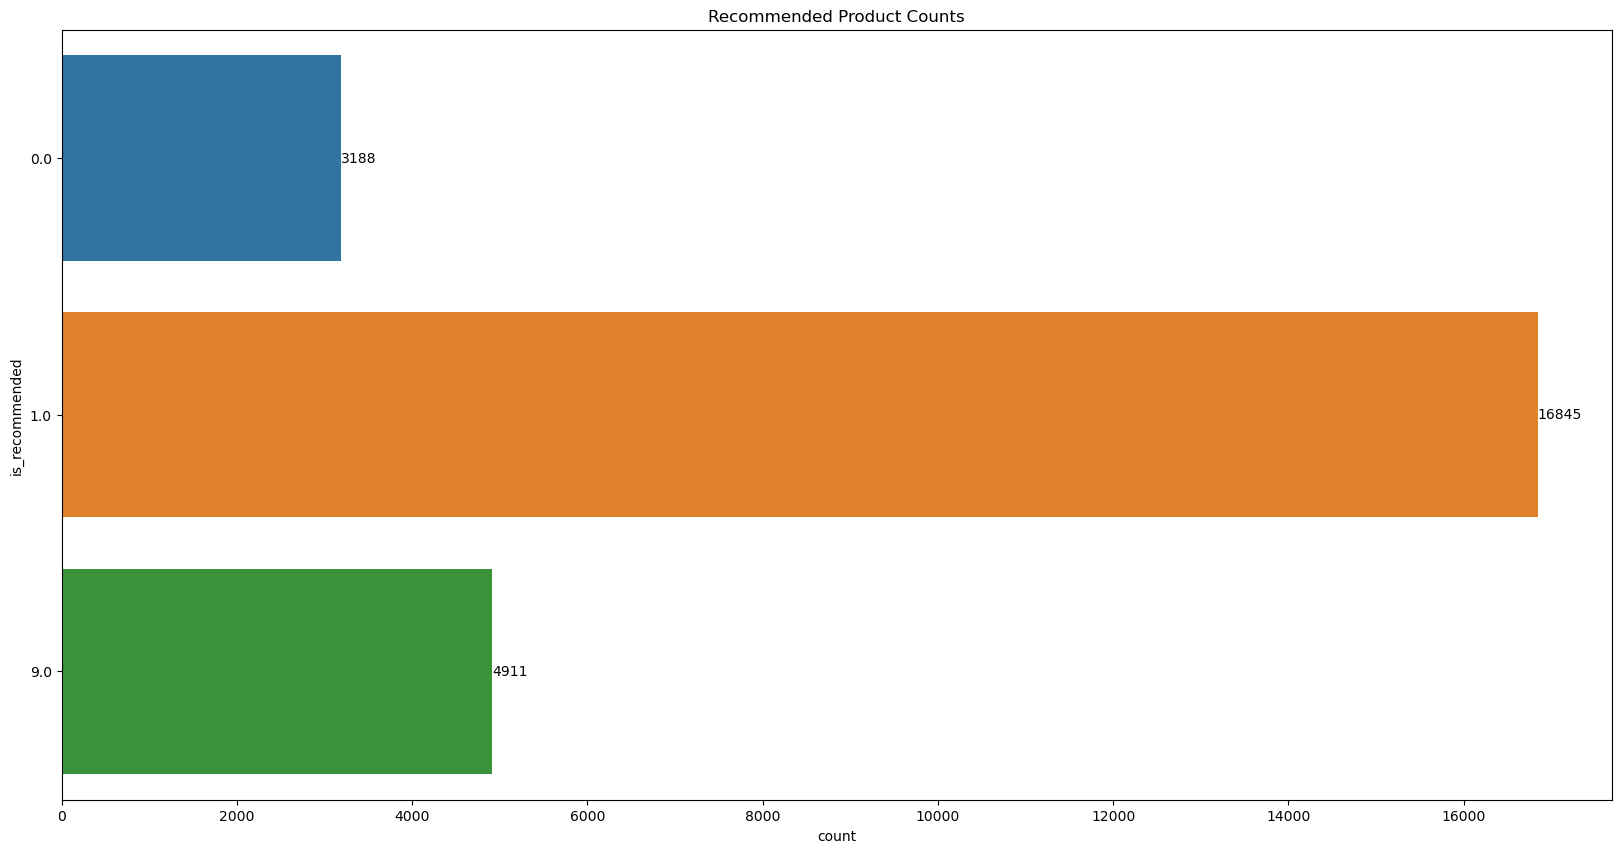

In [18]:
# is_recommended - this will have some null values that will need to be handled.
# The lack of a recommendation either way may also be interesting going forward.
# NaN will be replaced with 9
df2.is_recommended.fillna(9, inplace=True)

# Size
plt.figure(figsize=(20,10))

# Countplot
recommended_countplot = sns.countplot(y='is_recommended', data=df2)
recommended_countplot.bar_label(recommended_countplot.containers[0]) # Annotations
plt.title('Recommended Product Counts') # Title

# Show
plt.show()

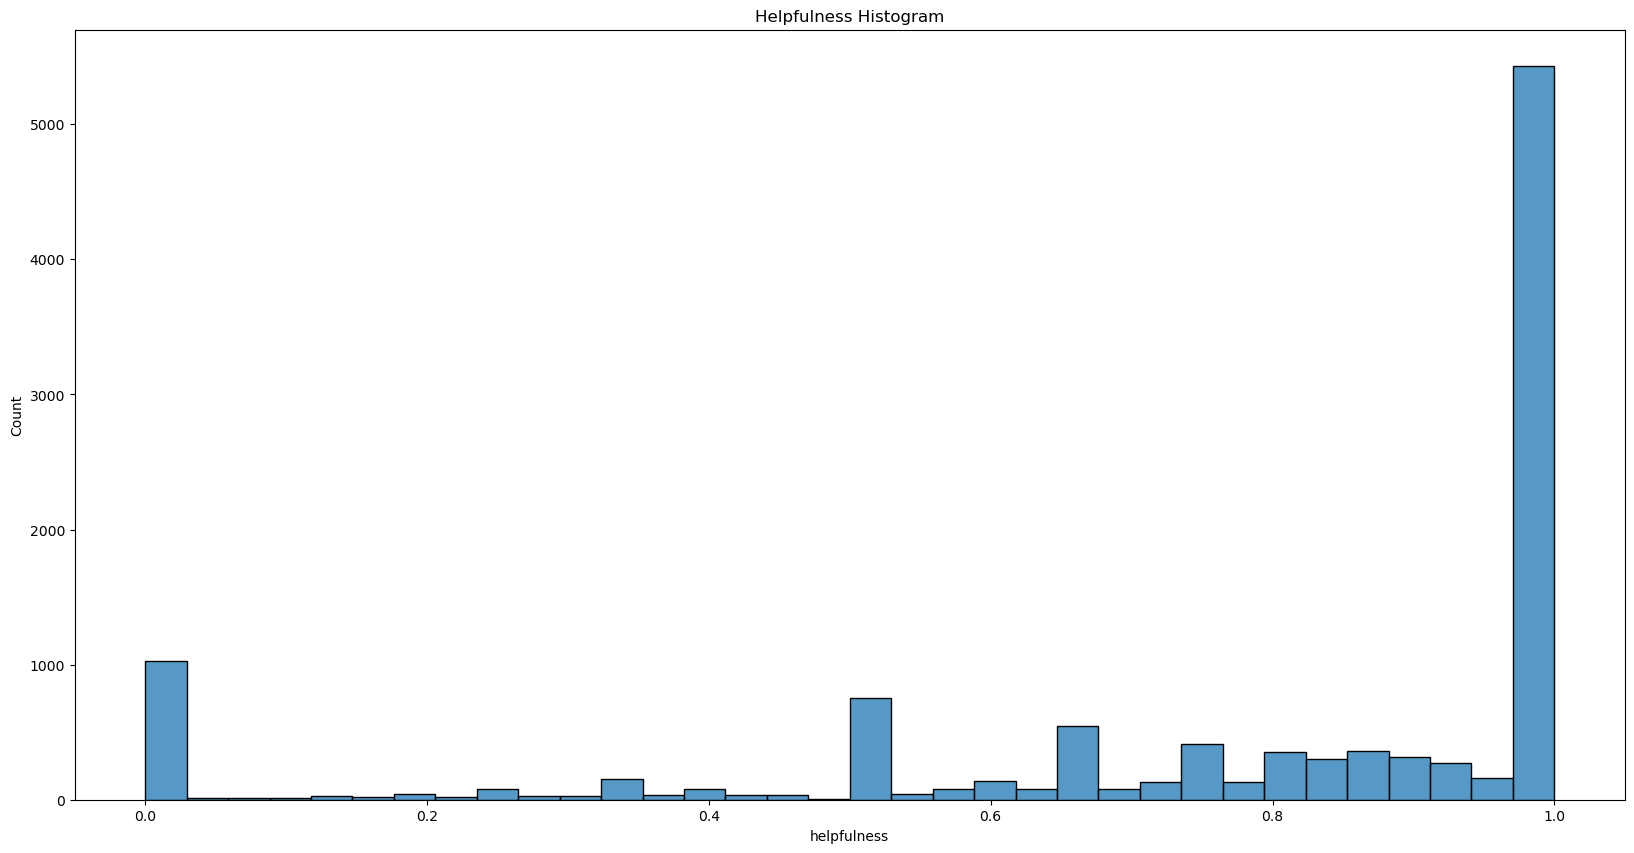

In [19]:
# Helpfulness - also contains a substantial amount of missing values that could impact the variable's use in a model.

# Size
plt.figure(figsize=(20, 10))

# Histogram
helpfulness_hist = sns.histplot(x='helpfulness', data=df2, stat='count')
plt.title('Helpfulness Histogram') # Title

# Show
plt.show()

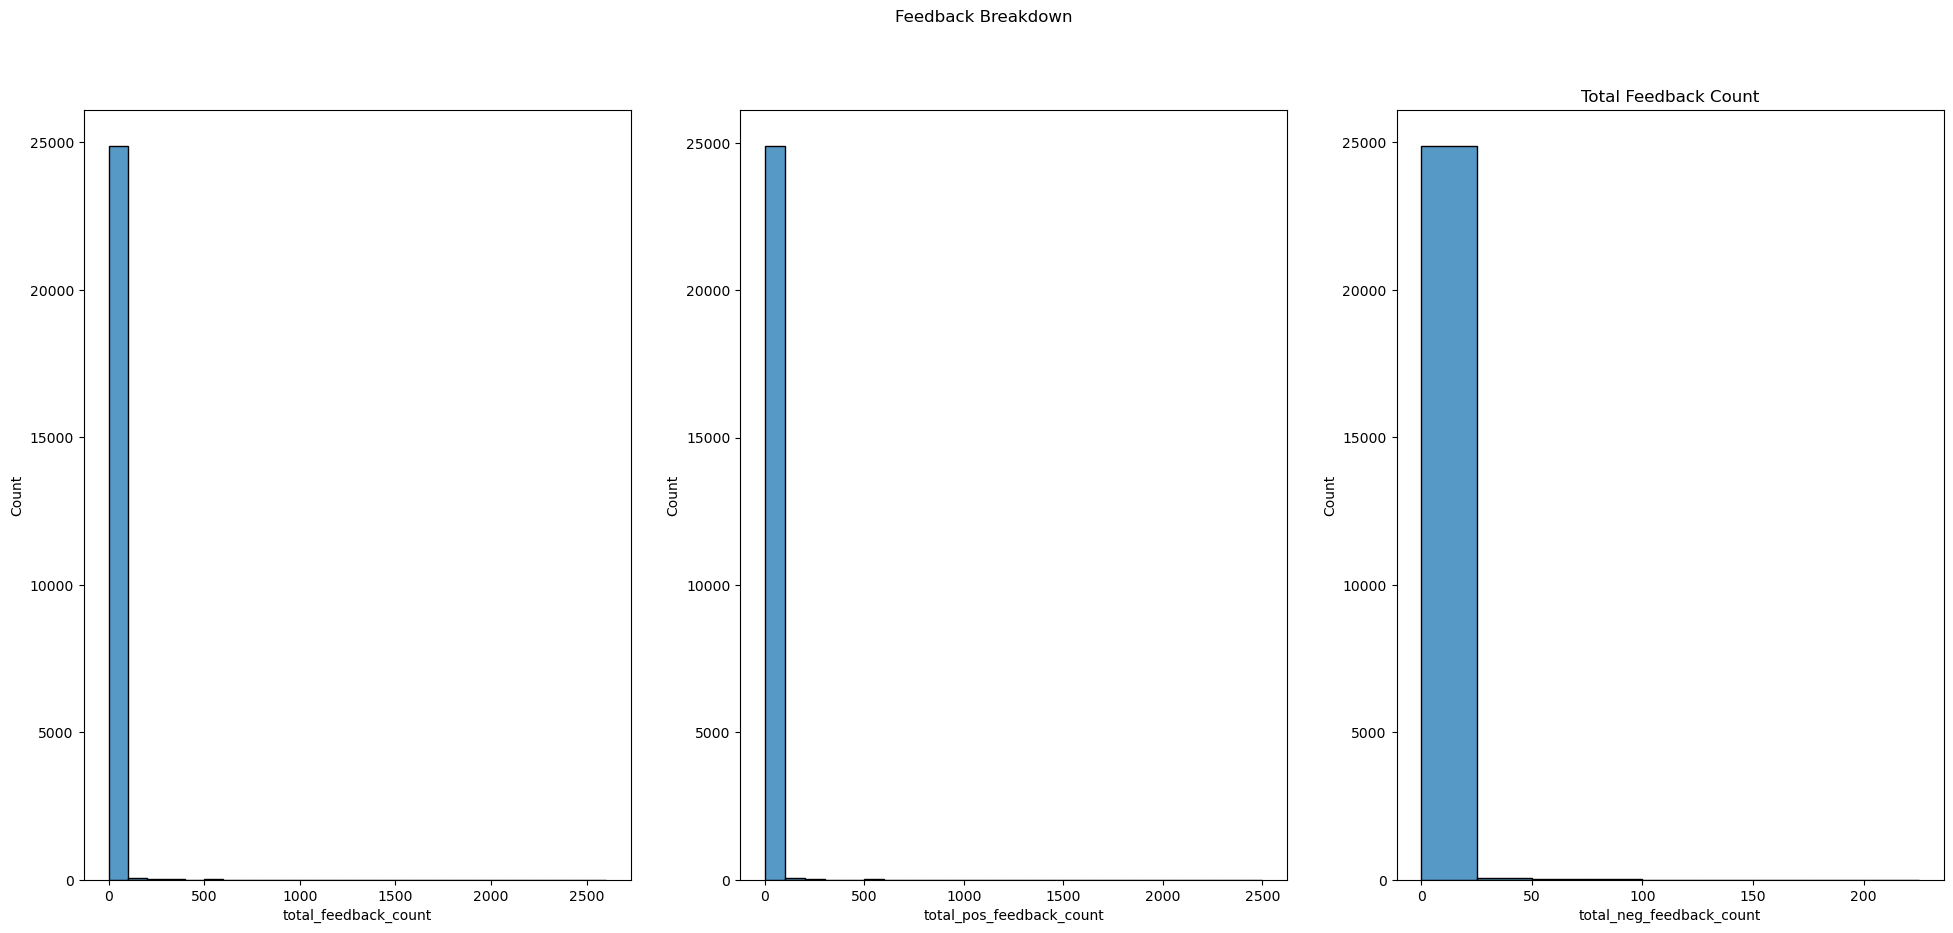

In [20]:
# Total feedback count, total positive feedback, total negative feedback
# Build subplots
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(24,10))

# ax0 - total feedback
sns.histplot(x='total_feedback_count', binwidth=100, data=df2, ax=ax0)
plt.title('Total Feedback Count')

# ax1 - total positive feedback
sns.histplot(x='total_pos_feedback_count', binwidth=100, data=df2, ax=ax1)
plt.title('Total Positive Feedback Count')

# ax2 - total negative feedback
sns.histplot(x='total_neg_feedback_count', binwidth=25, data=df2, ax=ax2)
plt.title('Total Feedback Count')

# Titling
plt.suptitle('Feedback Breakdown')

# Show
plt.show()

In [21]:
# Submission Time